## Installing Requirements

In [4]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /private/var/folders/jq/byrm2rk92d994w903r7jtzmw0000gn/T/pip-req-build-aqd8wfz9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/jq/byrm2rk92d994w903r7jtzmw0000gn/T/pip-req-build-aqd8wfz9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached torchvision-0.24.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.9 kB)
  Using cached torch-2.9.1-cp312-none-macosx_11_0_arm64.whl.metadata (30 kB)
Using cached torchvision-0.24.1-cp312-cp312-macosx_11_0_arm64.whl (1.9 MB)
Using cached torch-2.9.1-cp312-none-macosx_11_0_arm64.whl (74.5 MB)
  DEPRECATION: Building 'clip' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pe

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch.nn.functional as F
import scipy.ndimage

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and processor
model_name = "nlpconnect/vit-gpt2-image-captioning"
model = VisionEncoderDecoderModel.from_pretrained(model_name, attn_implementation="eager").to(device)
model.eval()
feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


Using device: cpu


In [2]:
import kagglehub
import os
import json

## Loading dataset & getting images with caption

In [3]:
# Download dataset
data_path = kagglehub.dataset_download(
    "nagasai524/mini-coco2014-dataset-for-image-captioning")

In [14]:
def load_captions(dataset_path):
    """Load image_id -> list of captions mapping from captions.json."""
    captions_path = os.path.join(dataset_path, "captions.json")
    with open(captions_path, "r") as f:
        data = json.load(f)

    annotations = data["annotations"] if isinstance(data, dict) else data

    captions = {}
    for ann in annotations:
        img_id = ann["image_id"]
        captions.setdefault(img_id, []).append(ann["caption"])
    return captions

In [5]:
def find_image_folder(dataset_path, ext=".jpg"):
    """Find first folder under dataset_path that contains image files."""
    for root, _, files in os.walk(dataset_path):
        if any(f.lower().endswith(ext) for f in files):
            return root
    raise RuntimeError(f"No image folder with *{ext} found under {dataset_path}")

In [6]:
captions = load_captions(data_path)
img_folder = find_image_folder(data_path)
img_ids = sorted(captions.keys())

print(f"Dataset loaded, {len(img_ids)} images with captions")

Dataset loaded, 18783 images with captions


In [15]:
def get_image(idx):
    """Load image and its captions by index in img_ids."""
    img_id = img_ids[idx]

    # Try common filename patterns
    candidates = [
        os.path.join(img_folder, f"COCO_train2014_{img_id:012d}.jpg"),
        os.path.join(img_folder, f"{img_id}.jpg"),
    ]

    for img_path in candidates:
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            return img, captions[img_id]

    raise FileNotFoundError(f"No image file found for image_id {img_id}")


In [8]:
idx = 6000
get_image(idx)

(<PIL.Image.Image image mode=RGB size=640x428>,
 ['A fluffy cat sleeping on the hood of a car',
  'A cat is laying on a car parked in a road in front of houses with a person standing in the background',
  'A cat is lying awake on a car hood',
  'The cat is lying down on top of a black car',
  'Cat relaxing on the hood of a car in an alley'])

## AAA Attack

First: ask for caption

In [16]:
def ask_generate_target_caption(original_caption, target_keywords=None):
    """
    Generate target caption for the attack.
    
    What this does:
    - Takes the original caption the model generates
    - Creates a NEW target caption that we want the model to output instead
    - This is the "goal" of our attack
    
    Args:
        original_caption: What the model currently says about the image
        target_keywords: Words we want in the attacked image's caption
        
    Returns:
        target_caption: The caption we're trying to force the model to generate
    """
    if target_keywords:
        target_caption = " ".join(target_keywords)
    else:
        # Default: Create a semantically different caption
        target_caption = "a flower on the kitchen table"
    
    print(f"\n{'='*60}")
    print(f"[STAGE 1: ASK]")
    print(f"{'='*60}")
    print(f"Original Caption: '{original_caption}'")
    print(f"Target Caption:   '{target_caption}'")
    print(f"Goal: Make the model say '{target_caption}' instead")
    
    return target_caption


Second: Attend to most important pixel areas

In [17]:
def attend_identify_crucial_regions(model, pixel_values, num_regions=16):
    """
    Identify the most important image regions using attention maps.
    
    Args:
        model: The VIT-GPT2 model
        pixel_values: Preprocessed image tensor [1, 3, 224, 224]
        num_regions: How many important patches to identify
        
    Returns:
        crucial_indices: Indices of the most important patches
        attention_map: Full attention weights for visualization
    """
    model.eval()
    
    print(f"\n{'='*60}")
    print(f"[STAGE 2: ATTEND]")
    print(f"{'='*60}")
    
    with torch.no_grad():
        # Get encoder outputs with attention weights
        encoder_outputs = model.encoder(
            pixel_values,
            output_attentions=True,  # This returns attention matrices
            return_dict=True
        )
        
        # The encoder has multiple layers, each with attention
        # attentions is a tuple: (layer1_attn, layer2_attn, ..., layer12_attn)
        attentions = encoder_outputs.attentions
        
        # Each attention tensor has shape: [batch_size, num_heads, seq_len, seq_len]
        # - num_heads: 12 (multi-head attention)
        # - seq_len: 197 (196 patches + 1 CLS token for 224x224 image with 16x16 patches)
        
        print(f"Number of attention layers: {len(attentions)}")
        print(f"Attention tensor shape: {attentions[0].shape}")
        
        # Aggregate attention across heads and layers
        attention_weights = []
        for attention in attentions:
            # Average over attention heads: [batch, seq_len, seq_len]
            avg_attention = attention.mean(dim=1)
            attention_weights.append(avg_attention)
        
        # Stack all layers and average: [batch, seq_len, seq_len]
        stacked_attention = torch.stack(attention_weights)
        avg_layer_attention = stacked_attention.mean(dim=0)
        
        # Focus on attention FROM the CLS token TO image patches
        # CLS token is at position 0, patches are positions 1-196
        cls_attention = avg_layer_attention[0, 0, 1:]
        
        # Normalize to get attention distribution
        attention_map = cls_attention / cls_attention.sum()
    
    # Find top-k most attended patches
    attention_scores = attention_map.cpu().numpy()
    crucial_indices = np.argsort(attention_scores)[-num_regions:]
    
    print(f"Identified {num_regions} crucial regions")
    print(f"Top 5 attention scores: {sorted(attention_scores)[-5:]}")
    print(f"These patches will be the focus of our attack")
    
    return crucial_indices, attention_map


def visualize_attention_map(image, attention_map, patch_size=16):
    """
    Visualize which image regions the model attends to.
    - Red/yellow areas: High attention (model focuses here)
    - Blue areas: Low attention (model ignores these)
    """
    img_array = np.array(image)
    h, w = img_array.shape[:2]
    
    # ViT processes 224x224 images with 16x16 patches = 14x14 grid
    num_patches_h = h // patch_size
    num_patches_w = w // patch_size
    
    # Reshape flat attention to 2D grid
    attention_scores = attention_map.cpu().numpy()
    attention_grid = attention_scores[:num_patches_h * num_patches_w].reshape(
        num_patches_h, num_patches_w
    )
    
    # Upsample attention map to match image size
    from scipy.ndimage import zoom
    zoom_factor = (h / num_patches_h, w / num_patches_w)
    attention_resized = zoom(attention_grid, zoom_factor, order=1)
    
    # Plot
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_array)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(attention_resized, cmap='jet')
    plt.title("Attention Heatmap")
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img_array)
    plt.imshow(attention_resized, alpha=0.5, cmap='jet')
    plt.title("Attention Overlay")
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Third: Attack

In [12]:
def generate_caption(pil_image):
    """Run vit-gpt2 on a single PIL image and return the caption string."""
    model.eval()
    inputs = feature_extractor(pil_image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        # NO num_beams here -> no beam search -> no _reorder_cache needed
        output_ids = model.generate(
            inputs,
            max_length=16,
            do_sample=False,   # greedy decoding
        )
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
    return caption


In [9]:
import re
import random
import numpy as np

import clip

# Load CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

def get_target_text_embedding(target_caption):
    """
    Compute CLIP text embedding for the target caption.
    """
    with torch.no_grad():
        text_tokens = clip.tokenize([target_caption]).to(device)
        text_emb = clip_model.encode_text(text_tokens)[0]
        text_emb = text_emb / text_emb.norm()
    return text_emb  # [D]

def clip_similarity_from_pixel_values(pixel_values, target_text_emb):
    """
    Compute CLIP image–text cosine similarity between a vit-gpt2 pixel_values tensor
    and a precomputed CLIP text embedding.
    """
    # Convert vit-gpt2 pixel_values back to a PIL image
    pil_img = pixel_values_to_pil(pixel_values)

    # Preprocess for CLIP
    image_input = clip_preprocess(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        img_emb = clip_model.encode_image(image_input)[0]
        img_emb = img_emb / img_emb.norm()

    sim = torch.nn.functional.cosine_similarity(img_emb, target_text_emb, dim=0)
    return sim.item()


# --- 2) Convert patch indices (from Attend) to pixel coordinates ---
def patches_to_pixel_coords(crucial_indices, image_size=224, patch_size=16, max_pixels=500):
    """
    Map ViT patch indices (0..num_patches-1) to pixel (y, x) coordinates.

    - image_size: 224 for vit-gpt2
    - patch_size: 16 for vit-gpt2 (14x14 patches)
    - max_pixels: sample at most this many pixels in total
    """
    num_patches_side = image_size // patch_size  # 14 for 224x224
    coords = []

    for idx in crucial_indices:
        row = idx // num_patches_side
        col = idx % num_patches_side
        y0 = row * patch_size
        x0 = col * patch_size

        for dy in range(patch_size):
            for dx in range(patch_size):
                y = y0 + dy
                x = x0 + dx
                coords.append((y, x))

    # Reduce search space further: randomly keep at most max_pixels
    if len(coords) > max_pixels:
        coords = random.sample(coords, max_pixels)

    return coords


# --- 3) Generate caption directly from pixel_values ---
def generate_caption_from_pixel_values(pixel_values):
    """
    pixel_values: [1, 3, 224, 224] tensor on any device.
    Returns: caption string.
    """
    model.eval()
    with torch.no_grad():
        output_ids = model.generate(
            pixel_values.to(device),
            max_length=16,
            do_sample=False,   # greedy decoding, NO beam search
        )
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
    return caption



# --- 4) Convert pixel_values back to a PIL image (for visualization only) ---
def pixel_values_to_pil(pixel_values):
    """
    Undo vit-gpt2 normalization and convert [1, 3, H, W] tensor to a PIL image.
    """
    pv = pixel_values.detach()[0]  # [3, H, W]

    mean = torch.tensor(feature_extractor.image_mean, device=pv.device).view(3, 1, 1)
    std = torch.tensor(feature_extractor.image_std, device=pv.device).view(3, 1, 1)

    img = pv * std + mean
    img = img.clamp(0.0, 1.0)

    arr = (img * 255).byte().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray(arr)


100%|███████████████████████████████████████| 338M/338M [00:31<00:00, 11.1MiB/s]


In [10]:
def aaa_attack_simple(
    pixel_values,
    target_caption,
    candidate_coords,
    pop_size=12,
    generations=15,
    F=0.6,
    CR=0.7,
    eps=0.05,
    lambda_smooth=0.0,
):
    """
    Simple Ask-Attend-Attack-style DE attack.

    Differences to previous version:
    - Objective is CLIP(image, target_caption) (smooth, as in the paper).
    - We optionally penalize big noise (lambda_smooth) if desired.
    """

    base = pixel_values.clone().detach().to(device)  # [1,3,224,224]
    D = len(candidate_coords) * 3  # 3 channels per pixel

    # Precompute CLIP text embedding for the target (Ask step)
    target_text_emb = get_target_text_embedding(target_caption)

    # --- Map genome -> noise tensor ---
    def genome_to_noise(genome_1d):
        noise = torch.zeros_like(base)
        g = torch.from_numpy(genome_1d).float().to(device)

        for idx, (y, x) in enumerate(candidate_coords):
            for c in range(3):
                noise[0, c, y, x] = g[3 * idx + c]
        return noise

    # --- Evaluate one individual: return (fitness, caption, clip_sim) ---
    def evaluate(genome_1d):
        noise = genome_to_noise(genome_1d)
        adv = torch.clamp(base + noise, -10.0, 10.0)  # stay numerically sane

        # CLIP similarity (we want this HIGH)
        sim_clip = clip_similarity_from_pixel_values(adv, target_text_emb)

        # Optional small-noise penalty (L2 on genome)
        penalty = 0.0
        if lambda_smooth > 0:
            penalty = lambda_smooth * float(np.linalg.norm(genome_1d, ord=2))

        fitness = -sim_clip + penalty   # minimize fitness -> maximize sim_clip

        # Caption is only for logging, not for optimization
        caption = generate_caption_from_pixel_values(adv)
        return fitness, caption, sim_clip

    # --- 1) Initialize population in [-eps, eps] ---
    pop = np.random.uniform(-eps, eps, size=(pop_size, D)).astype(np.float32)
    fitness = np.zeros(pop_size, dtype=np.float32)
    captions = [""] * pop_size
    sims = np.zeros(pop_size, dtype=np.float32)

    best_idx = 0
    best_fit = float("inf")
    best_caption = None
    best_sim = -1e9

    for i in range(pop_size):
        f, cap, sim = evaluate(pop[i])
        fitness[i] = f
        captions[i] = cap
        sims[i] = sim

        if f < best_fit:
            best_fit = f
            best_idx = i
            best_caption = cap
            best_sim = sim

    print(f"Initial best fitness: {best_fit:.4f} | CLIP sim={best_sim:.4f}")
    print("  caption:", best_caption)

    # --- 2) Differential Evolution loop ---
    for gen in range(generations):
        for i in range(pop_size):
            idxs = [j for j in range(pop_size) if j != i]
            r1, r2, r3 = np.random.choice(idxs, 3, replace=False)

            # Mutation
            mutant = pop[r1] + F * (pop[r2] - pop[r3])

            # Crossover
            cross_points = np.random.rand(D) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, D)] = True
            trial = np.where(cross_points, mutant, pop[i])
            trial = np.clip(trial, -eps, eps)

            # Evaluate trial
            f_trial, cap_trial, sim_trial = evaluate(trial)

            # Selection
            if f_trial <= fitness[i]:
                pop[i] = trial
                fitness[i] = f_trial
                captions[i] = cap_trial
                sims[i] = sim_trial

                if f_trial < best_fit:
                    best_fit = f_trial
                    best_idx = i
                    best_caption = cap_trial
                    best_sim = sim_trial

        print(
            f"Generation {gen+1}/{generations} | "
            f"best fitness={best_fit:.4f} | CLIP sim={best_sim:.4f}"
        )
        print("  best caption so far:", best_caption)

    # --- 3) Build final adversarial image ---
    best_genome = pop[best_idx]
    best_noise = genome_to_noise(best_genome)
    best_adv = torch.clamp(base + best_noise, -10.0, 10.0)

    return best_adv, best_caption


Image index: 6000
Some ground-truth captions from dataset:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood

[STAGE 1: ASK]
Original Caption: 'a cat laying on top of a car'
Target Caption:   'a flower on the kitchen table'
Goal: Make the model say 'a flower on the kitchen table' instead

[STAGE 2: ATTEND]
Number of attention layers: 12
Attention tensor shape: torch.Size([1, 12, 197, 197])
Identified 16 crucial regions
Top 5 attention scores: [0.017056957, 0.03507773, 0.050339095, 0.06981847, 0.100733876]
These patches will be the focus of our attack

Number of candidate pixels to attack: 4096
Initial best fitness: -0.1842 | CLIP sim=0.1842
  caption: a cat laying on top of a car
Generation 1/20 | best fitness=-0.1864 | CLIP sim=0.1864
  best caption so far: a cat laying on top of a car
Generation 2/20 | best fitness=-0.1873 | CLIP sim=0.1873
  b

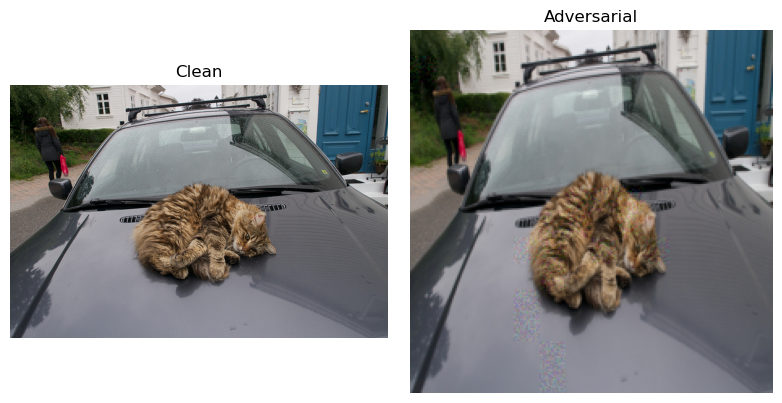

In [19]:
# ========== EXAMPLE: AAA-style attack on one image (idx = 6000) ==========

idx = 6000
clean_img, clean_caps = get_image(idx)

print("Image index:", idx)
print("Some ground-truth captions from dataset:")
for c in clean_caps[:3]:
    print("  -", c)

# 1) Get model's original caption (Ask stage in a simple form)
original_caption = generate_caption(clean_img)
target_caption = ask_generate_target_caption(original_caption)  # uses your helper

# 2) Preprocess image for vit-gpt2
inputs = feature_extractor(clean_img, return_tensors="pt")
pixel_values = inputs.pixel_values.to(device)  # [1,3,224,224]

# 3) Attend: find crucial regions using your attention function
crucial_indices, attention_map = attend_identify_crucial_regions(
    model, pixel_values, num_regions=16
)

# Turn those patch indices into actual pixels we are allowed to modify
candidate_coords = patches_to_pixel_coords(
    crucial_indices,
    image_size=pixel_values.shape[-1],  # 224
    patch_size=16,
    max_pixels=5000,                     # keep search small
)

print(f"\nNumber of candidate pixels to attack: {len(candidate_coords)}")

# 4) Attack: run simple Differential Evolution attack on those pixels
adv_pixel_values, adv_caption = aaa_attack_simple(
    pixel_values=pixel_values,
    target_caption=target_caption,
    candidate_coords=candidate_coords,
    pop_size=20,        # keep small for speed
    generations=20,     # also small
    F=0.6,
    CR=0.7,
    eps=0.1,           # max change in vit-gpt2 input space
)

# 5) Compare captions and visualize
adv_img = pixel_values_to_pil(adv_pixel_values)

print("\n========== RESULTS ==========")
print("Original caption: ", original_caption)
print("Target caption:   ", target_caption)
print("Adversarial cap:  ", adv_caption)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(clean_img)
plt.title("Clean")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title("Adversarial")
plt.axis("off")

plt.tight_layout()
plt.show()
